## Notebook Overview: Data Preparation

This notebook prepares a merged county-year panel dataset that integrates demographic, economic, and environmental data for exploratory analysis and modeling. The workflow includes:

- Loading and cleaning ACS, weather, and storm event data  
- Mapping NOAA weather stations to U.S. counties via spatial joins  
- Aggregating and merging data at the county-year level  
- Engineering time-series features like year-over-year changes and rolling averages  
- Exporting a modeling-ready subset with complete demographic coverage

The resulting dataset supports longitudinal analysis of climate impacts and regional socioeconomic trends across U.S. counties.


In [2]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import datetime as dt
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm



# Base data directory
DATA_DIR = Path("data")

### Load and Process Urban-Rural Classification Data

This section reads in the USDA rural-urban continuum codes, pivots the dataset into a wide format by county, and creates a simplified urban classification variable (`urban_classification`) based on RUCC 2023 codes.


In [3]:
county_type_dtypes = {
    "FIPS": str
}
county_type_df = pd.read_csv(DATA_DIR / "Ruralurbancontinuumcodes2023.csv", dtype=county_type_dtypes, encoding="latin1")

# Pivot into wide format
county_type_wide = county_type_df.pivot_table(
    index=["FIPS", "State", "County_Name"],
    columns="Attribute",
    values="Value",
    aggfunc="first"
).reset_index()

# Clean up column names (flatten MultiIndex if any)
county_type_wide.columns.name = None

county_type_wide.rename(columns={"FIPS": "geo_id"}, inplace=True)

county_type_wide["RUCC_2023"] = county_type_wide["RUCC_2023"].fillna(0)
county_type_wide["urban_classification"] = county_type_wide["RUCC_2023"].astype(int).map(lambda x: "unknown" if x == 0 else "urban" if 1 <= x <=3 else "suburban" if 4 <= x <= 6 else "rural")

# Preview
print(county_type_wide.head())



  geo_id State     County_Name  \
0  01001    AL  Autauga County   
1  01003    AL  Baldwin County   
2  01005    AL  Barbour County   
3  01007    AL     Bibb County   
4  01009    AL   Blount County   

                                         Description Population_2020  \
0  Metro - Counties in metro areas of 250,000 to ...           58805   
1  Metro - Counties in metro areas of fewer than ...          231767   
2  Nonmetro - Urban population of 5,000 to 20,000...           25223   
3  Metro - Counties in metro areas of 1 million p...           22293   
4  Metro - Counties in metro areas of 1 million p...           59134   

  RUCC_2023 urban_classification  
0         2                urban  
1         3                urban  
2         6             suburban  
3         1                urban  
4         1                urban  


### Load and Clean ACS Demographic Data

This block loads the multi-year county-level ACS dataset, ensures consistent FIPS formatting, removes rows with missing income data, and imputes median values for minor gaps in select socioeconomic indicators.


In [4]:
acs_dtypes = {
    "geo_id": str,
    "year": int,
    "median_income": float,
    "total_pop": int,
    "median_age": float,
    "white_pop": float,
    "black_pop": float,
    "hispanic_pop": float,
    "asian_pop": float,
    "bachelors_degree_or_higher_25_64": float,
    "less_than_high_school_graduate": float,
    "some_college_and_associates_degree": float,
    "percent_income_spent_on_rent": float,
    "different_house_year_ago_same_city": float,
    "different_house_year_ago_different_city": float,
    "median_rent": float,
    "rent_over_50_percent": float,    
    "poverty": float,
    "gini_index": float
}

acs_df = pd.read_csv(DATA_DIR / "acs_multi_year_panel.csv", dtype=acs_dtypes)

# Sanity check FIPS formatting
acs_df["geo_id"] = acs_df["geo_id"].str.zfill(5)

# Drop nulls in income (2 rows)
acs_df = acs_df.dropna(subset=["median_income"])

# Fill minor gaps with  less than 10 nulls
minor_cols = ["median_rent", "percent_income_spent_on_rent", "rent_over_50_percent", "poverty", "gini_index"]
acs_df[minor_cols] = acs_df[minor_cols].fillna(acs_df[minor_cols].median())

acs_df.head()

,geo_id,state_fips,county_fips,year,median_income,total_pop,median_age,white_pop,black_pop,hispanic_pop,...,bachelors_degree_or_higher_25_64,less_than_high_school_graduate,some_college_and_associates_degree,different_house_year_ago_same_city,different_house_year_ago_different_city,median_rent,percent_income_spent_on_rent,rent_over_50_percent,poverty,gini_index
0,05025,5,25,2020,46349.0,8063,42.5,6807.0,1087.0,0.0,...,766.0,601.0,1579.0,41.0,360.0,379.0,20.2,72.0,1173.0,0.4314
1,08009,8,9,2020,34655.0,3570,45.9,3005.0,33.0,404.0,...,393.0,369.0,896.0,138.0,257.0,316.0,21.2,35.0,625.0,0.4696
2,13307,13,307,2020,31629.0,2587,43.9,1372.0,850.0,322.0,...,141.0,378.0,673.0,60.0,113.0,237.0,34.7,0.0,637.0,0.4986
3,16059,16,59,2020,38819.0,7929,53.4,7408.0,2.0,264.0,...,927.0,483.0,2490.0,194.0,847.0,514.0,35.6,147.0,1063.0,0.4570
4,16077,16,77,2020,51014.0,7635,38.8,4682.0,2.0,2596.0,...,583.0,951.0,1366.0,882.0,674.0,483.0,18.6,16.0,915.0,0.4167


### Load and Transform Quarterly Weather Data

This section loads GSOD weather summaries, removes unused columns, aggregates annual precipitation and heat days, and pivots average temperatures by quarter. The final dataset merges these metrics into a single weather summary per station-year.


In [5]:
weather_dtypes = {
    "station_id": str,
    "year": int,
    "quarter": int,
    "avg_temp": float,
    "max_temp": float,
    "total_precip": float,
    "heat_days_90F": int
}

# Load GSOD aggregates
weather_df = pd.read_csv(DATA_DIR / "gsod_quarterly_aggregates.csv", dtype=weather_dtypes)

# Drop redundant columns
weather_df = weather_df.drop(columns=["hail_days", "thunder_days", "tornado_days"], errors="ignore")

# Sum heat_days_90F and num_days across quarters
annual_sums = weather_df.groupby(["station_id", "year"])[["heat_days_90F", "total_precip"]].sum().reset_index()

# Preserve max_temp, min_temp and avg_temp for each year
annual_max = weather_df.groupby(["station_id", "year"])[["max_temp"]].max().reset_index()

# Pivot avg_temp, max_temp, and total_precip by quarter
pivoted = weather_df.pivot_table(
    index=["station_id", "year"],
    columns="quarter",
    values=["avg_temp"]
).reset_index()

# Flatten the multi-index column names
pivoted.columns = ['station_id', 'year'] + [
    f"{var}_q{q}" for var, q in pivoted.columns[2:]
]

# Merge pivoted and temp results
weather_df = pivoted.merge(annual_sums, on=["station_id", "year"], how="left")
weather_df = weather_df.merge(annual_max, on=["station_id", "year"], how="left")

weather_df.head()

,station_id,year,avg_temp_q1,avg_temp_q2,avg_temp_q3,avg_temp_q4,heat_days_90F,total_precip,max_temp
0,007018-99999,2011,58.295652,76.295455,87.900000,NaN,65,0.0,116.6
1,007018-99999,2013,NaN,NaN,81.190909,NaN,6,0.0,102.2
2,007019-99999,2013,NaN,80.520000,77.000000,NaN,4,0.0,98.6
3,007026-99999,2014,NaN,NaN,73.800000,43.3125,0,0.0,84.2
4,007026-99999,2016,NaN,83.300000,NaN,NaN,4,0.0,100.4


### Load NOAA Weather Station Metadata

This block reads metadata for NOAA weather stations, including identifiers, geographic coordinates, and operational date ranges. Elevation is preserved as a string to retain formatting.


In [6]:
station_dtype = {
    "usaf": str,
    "wban": str,
    "name": str,
    "country": str,
    "state": str,
    "lat": float,
    "lon": float,
    "elev": str  # keep as str to preserve sign and format
    }

# Load file
stations_df = pd.read_csv(
    DATA_DIR / "noaa_stations.csv",
    dtype=station_dtype,
    parse_dates=["begin", "end"]
)

stations_df.head()

,usaf,wban,name,country,state,lat,lon,elev,begin,end,station_id
0,690020,99999,JOLON HUNTER LIGGETT MIL RES,US,CA,36.000,-121.233,+0317.0,2003-07-02,2003-08-01,690020-99999
1,690190,13910,ABILENE DYESS AFB,US,TX,32.433,-99.850,+0545.3,1943-12-01,2009-12-31,690190-13910
2,690190,99999,DYESS AFB/ABILENE,US,TX,32.417,-99.850,+0545.0,2000-01-03,2004-12-30,690190-99999
3,690230,24255,WHIDBEY ISLAND NAS,US,WA,48.350,-122.667,+0014.3,1989-12-01,2009-06-02,690230-24255
4,690260,99999,CHEBOYGAN,US,MI,45.650,-84.467,+0176.0,1980-06-11,2001-10-23,690260-99999


### Load County-Level Storm Event Data

This block imports annual storm event summaries by county, including event counts, property and crop damage, injuries, and fatalities for each event type.


In [7]:
storm_dtypes = {
    "geo_id": str,
    "year": int,
    "event_type": str,
    "num_events": int,
    "total_property_damage": float,
    "total_crop_damage": float,
    "total_injuries": int,
    "total_deaths": int
}

storm_df = pd.read_csv(DATA_DIR / "storm_events_by_county_year.csv", dtype=storm_dtypes)

print("Loaded storm event data:", storm_df.shape)
storm_df.head()

Loaded storm event data: (215730, 8)


,geo_id,year,event_type,num_events,total_property_damage,total_crop_damage,total_injuries,total_deaths
0,33007,2000,debris flow,1,0.0,0.0,0,0
1,36001,2000,debris flow,1,500000.0,0.0,0,0
2,51009,2000,dust devil,1,3000.0,0.0,0,0
3,32031,2000,dust devil,1,1000.0,0.0,0,0
4,21015,2000,flash flood,3,25000.0,0.0,0,0


### Load and Prepare U.S. County Shapefile

This section reads the 2023 county shapefile, reprojects it to WGS84 for geographic consistency, generates a FIPS-based join key, and retains relevant spatial attributes for merging.


In [8]:
shapefile_path = Path("Data/cb_2023_us_county_5m/cb_2023_us_county_5m.shp")

counties = gpd.read_file(shapefile_path)

# Project to WGS84 (matches lat/lon)
counties = counties.to_crs("EPSG:4326")

# Create a unique FIPS code for join
counties["geo_id"] = counties["STATEFP"] + counties["COUNTYFP"]

# Select relevant columns
counties = counties[["geo_id", "NAME", "STATEFP", "COUNTYFP", "geometry"]]
counties.head()

,geo_id,NAME,STATEFP,COUNTYFP,geometry
0,13065,Clinch,13,065,"POLYGON ((-82.9705 30.94981, -82.97125 31.1839..."
1,21083,Graves,21,083,"POLYGON ((-88.81724 36.76775, -88.81323 36.773..."
2,37177,Tyrrell,37,177,"POLYGON ((-76.4056 35.78629, -76.35367 35.8613..."
3,38013,Burke,38,013,"POLYGON ((-102.93896 48.99928, -102.67765 48.9..."
4,40059,Harper,40,059,"POLYGON ((-100.00371 36.79697, -100.00256 37.0..."


### Join Weather Stations to Counties via Spatial Merge

This section converts NOAA stations to a GeoDataFrame and performs a spatial join with county boundaries to assign each station to a county. The resulting dataset links weather records to counties using FIPS codes for downstream merging with demographic data.


In [9]:
# Convert stations_df to a GeoDataFrame
stations_gdf = gpd.GeoDataFrame(
    stations_df,
    geometry=gpd.points_from_xy(stations_df["lon"], stations_df["lat"]),
    crs="EPSG:4326"
)

# Perform spatial join (retains station geometry by default)
joined = gpd.sjoin(
    stations_gdf,
    counties[["geo_id", "NAME", "geometry"]],
    how="left",
    predicate="within"
)

# Rename county geometry to keep it
joined = joined.rename(columns={"geometry": "station_geometry", "NAME": "county_name"})

# Add back county geometry explicitly
joined = joined.merge(
    counties[["geo_id", "geometry"]].rename(columns={"geometry": "county_geometry"}),
    on="geo_id",
    how="left"
)

# Keep what's relevant, now with county geometry
stations_with_fips = gpd.GeoDataFrame(
    joined[["station_id", "geo_id", "county_name", "lat", "lon", "county_geometry"]],
    geometry="county_geometry",
    crs="EPSG:4326"
)

# Filter out non-US stations
weather_df = weather_df[weather_df["station_id"].isin(stations_with_fips["station_id"])]

# Merge Weather and Station data to eventually merge with ACS data
weather_df = weather_df.merge(stations_with_fips[["station_id", "geo_id", "county_name", "county_geometry"]], on="station_id", how="left")

### Pivot Storm Event Data by Type

This function reshapes the storm dataset by pivoting event counts (`num_events`) across event types for each county-year. Additionally, it filters to the top N event types based on combined death and damage impact. Outcome metrics (e.g., deaths, injuries, damages) are aggregated separately and merged into the final wide-format table.


In [10]:
def pivot_storm_events_by_type(
    storm_df: pd.DataFrame,
    top_n: int = None
) -> pd.DataFrame:
    
    storm_df = storm_df.copy()
    event_metrics = [
        "num_events"
    ]
    outcome_metrics = [
        "total_injuries",
        "total_deaths",
        "total_property_damage",
        "total_crop_damage"
    ]

     # Fill any nulls
    storm_df[event_metrics + outcome_metrics] = storm_df[event_metrics + outcome_metrics].fillna(0)

    # Auto-select most impactful event types
    if top_n is not None:
        summary = storm_df.groupby("event_type").agg(
            total_deaths=("total_deaths", "sum"),
            total_damage=("total_property_damage", "sum")
        )
        summary["combined_impact"] = summary["total_deaths"] + (summary["total_damage"] / 1_000_000)  # scale damage
        top_event_types = summary.sort_values(by="combined_impact", ascending=False).head(top_n).index.tolist()
        storm_df = storm_df[storm_df["event_type"].isin(top_event_types)]

    # Pivot only the num_events by type
    event_pivot = storm_df.pivot_table(
        index=["geo_id", "year"],
        columns="event_type",
        values=event_metrics,
        aggfunc="sum",
        fill_value=0
    )

    # Flatten pivoted columns
    event_pivot.columns = [
        f"{metric}_{event_type.replace(' ', '_').lower()}"
        for metric, event_type in event_pivot.columns
    ]
    
    event_pivot = event_pivot.reset_index()

    # Summarize total impacts across all event types
    outcome_summary = storm_df.groupby(["geo_id", "year"])[outcome_metrics].sum().reset_index()

    # Merge them
    result = pd.merge(event_pivot, outcome_summary, on=["geo_id", "year"], how="left")
    
    return result


In [11]:
# Run severe weather data through function to flatten data and highlight most impactful events
storm_wide = pivot_storm_events_by_type(storm_df, top_n=10)
print(storm_wide.columns)

Index(['geo_id', 'year', 'num_events_debris_flow', 'num_events_flash_flood',
       'num_events_flood', 'num_events_hail', 'num_events_heavy_rain',
       'num_events_lightning', 'num_events_rip_current',
       'num_events_thunderstorm_wind', 'num_events_tornado',
       'num_events_wildfire', 'total_injuries', 'total_deaths',
       'total_property_damage', 'total_crop_damage'],
      dtype='object')


### Aggregate Weather Data to County-Year Level

This step aggregates station-level weather data to the county-year level to align with the structure of ACS demographic data. Quarterly temperature and precipitation values are averaged, the annual maximum temperature is preserved, and the number of contributing stations per county is counted. Although the original weather data was processed at the quarterly level, annual aggregation ensures consistency across all modeling inputs.


In [12]:
# Aggregate weather data to county-year level
county_weather_annual = weather_df.groupby(
    ["geo_id", "county_name", "year", "county_geometry"]
).agg(
    avg_temp_q1=("avg_temp_q1", "mean"),
    avg_temp_q2=("avg_temp_q2", "mean"),
    avg_temp_q3=("avg_temp_q3", "mean"),
    avg_temp_q4=("avg_temp_q4", "mean"),
    max_temp=("max_temp", "max"),
    total_precip=("total_precip", "mean"),
    heat_days_90F=("heat_days_90F", "mean"),
    reporting_stations=("station_id", "nunique")
).reset_index()

county_weather_annual.head()

,geo_id,county_name,year,county_geometry,avg_temp_q1,avg_temp_q2,avg_temp_q3,avg_temp_q4,max_temp,total_precip,heat_days_90F,reporting_stations
0,01003,Baldwin,2006,"POLYGON ((-88.02927 30.22271, -88.02399 30.230...",NaN,78.274468,79.402209,58.596920,96.8,10.300000,30.00,2
1,01003,Baldwin,2007,"POLYGON ((-88.02927 30.22271, -88.02399 30.230...",53.967616,71.111974,79.982125,59.784863,95.4,17.693333,20.00,3
2,01003,Baldwin,2008,"POLYGON ((-88.02927 30.22271, -88.02399 30.230...",53.738940,71.850580,77.982304,57.232076,95.0,18.585000,6.25,4
3,01003,Baldwin,2009,"POLYGON ((-88.02927 30.22271, -88.02399 30.230...",54.519655,76.666241,79.424095,60.396732,102.7,22.940000,29.75,4
4,01003,Baldwin,2010,"POLYGON ((-88.02927 30.22271, -88.02399 30.230...",49.955890,74.181242,81.672909,58.082257,102.2,14.297500,45.00,4


### Merge Demographic, Weather, and Storm Data

This section combines county-level weather summaries with ACS demographic data, storm event metrics, and rural-urban classifications. Missing storm data is imputed with zeros, and a `has_acs` flag is added to indicate records with available ACS data for modeling.


In [13]:
# Merge ACS data with county level quarterly weather data
weather_with_acs = county_weather_annual.merge(
    acs_df,
    on=["geo_id", "year"],
    how="left"
)

# Include severe weather data with the merged df
weather_with_acs = weather_with_acs.merge(storm_wide, on=["geo_id", "year"], how="left")

# Include severe weather data with the merged df
weather_with_acs = weather_with_acs.merge(county_type_wide, on=["geo_id"], how="left")

# Only fill NaNs in storm event fields (exclude things like total_pop, total_precip, etc.)
storm_cols = [
    col for col in storm_wide.columns
    if col not in ["geo_id", "year", "quarter"]
]

# Fill storm data columns only
weather_with_acs[storm_cols] = weather_with_acs[storm_cols].fillna(0)

# Flag for downstream modeling since we have more  weather data than acs data currently
weather_with_acs["has_acs"] = weather_with_acs["median_income"].notna().astype(int)

weather_with_acs.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36019 entries, 0 to 36018
Data columns (total 52 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   geo_id                                   36019 non-null  object  
 1   county_name                              36019 non-null  object  
 2   year                                     36019 non-null  int32   
 3   county_geometry                          36019 non-null  geometry
 4   avg_temp_q1                              35237 non-null  float64 
 5   avg_temp_q2                              35534 non-null  float64 
 6   avg_temp_q3                              35723 non-null  float64 
 7   avg_temp_q4                              35778 non-null  float64 
 8   max_temp                                 36019 non-null  float64 
 9   total_precip                             36019 non-null  float64 
 10  heat_days_90F                     

### Compute Change Metrics for Key Socioeconomic Variables

This block calculates year-over-year (YoY) changes, percent changes, and 3-year rolling averages for selected socioeconomic indicators at the county level to capture temporal trends and volatility over time.


In [14]:
change_cols = [
    "median_income",
    "total_pop",
    "poverty",
    "gini_index",
    "percent_income_spent_on_rent",
    "rent_over_50_percent"
]

for col in change_cols:
    group = weather_with_acs.groupby("geo_id")[col]

    # YoY change
    weather_with_acs[col + "_change"] = group.diff().fillna(0).replace([np.inf, -np.inf], 0)

    # Percent change
    weather_with_acs[col + "_pct_yoy"] = group.pct_change(fill_method=None).fillna(0) * 100
    weather_with_acs[col + "_pct_yoy"] = weather_with_acs[col + "_pct_yoy"].replace([np.inf, -np.inf], 0)

    # 3-year rolling average
    weather_with_acs[col + "_roll3"] = group.transform(lambda x: x.rolling(window=3, min_periods=1).mean())


### Generate Lag and Rolling Features for Weather and Storm Predictors

This section creates lagged (previous year) and 3-year rolling average features for key weather and storm indicators, enabling temporal modeling of environmental trends. Original predictor columns are dropped after transformation to reduce redundancy.


In [15]:
weather_predictors = [
    "avg_temp_q1", "avg_temp_q2", "avg_temp_q3", "avg_temp_q4",
    "max_temp", "total_precip", "heat_days_90F",
    "total_injuries", "total_deaths", "total_property_damage", "total_crop_damage",
    "num_events_debris_flow", "num_events_flash_flood", "num_events_flood",  "num_events_hail", "num_events_heavy_rain",
    "num_events_lightning", "num_events_rip_current", "num_events_thunderstorm_wind", "num_events_tornado", "num_events_wildfire"
]

for col in weather_predictors:
    weather_with_acs[f"{col}_lag1"] = (
        weather_with_acs.sort_values(["geo_id", "year"])
        .groupby("geo_id")[col]
        .shift(1)
    )

for col in weather_predictors:
    weather_with_acs[f"{col}_roll3"] = (
        weather_with_acs.sort_values(["geo_id", "year"])
        .groupby("geo_id")[col]
        .transform(lambda x: x.rolling(3, min_periods=1).mean())
    )
    
weather_with_acs = weather_with_acs.drop(columns=weather_predictors)



### Export Final Datasets for Modeling

This block saves two output files: one for model training (counties with ACS data) and another containing the full merged dataset, including records with missing demographic values.


In [16]:
# Training only subset
training_data = weather_with_acs[weather_with_acs["has_acs"] == 1].copy()
training_data.to_csv(DATA_DIR / "county_weather_acs_training.csv", index=False)

# Store complete dataset including nulls
weather_with_acs.to_csv(DATA_DIR / "county_weather_acs_complete.csv", index=False)

print("Merged shape:", weather_with_acs.shape)
print("Training shape:", training_data.shape)

Merged shape: (36019, 91)
Training shape: (16860, 91)


In [17]:
weather_with_acs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36019 entries, 0 to 36018
Data columns (total 91 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   geo_id                                   36019 non-null  object  
 1   county_name                              36019 non-null  object  
 2   year                                     36019 non-null  int32   
 3   county_geometry                          36019 non-null  geometry
 4   reporting_stations                       36019 non-null  int64   
 5   state_fips                               16860 non-null  float64 
 6   county_fips                              16860 non-null  float64 
 7   median_income                            16860 non-null  float64 
 8   total_pop                                16860 non-null  float64 
 9   median_age                               16860 non-null  float64 
 10  white_pop                         

## Summary: Prepared Panel Dataset

By the end of this notebook, we generated:

- A cleaned and enriched dataset (`county_weather_acs_training.csv`) for counties with full ACS coverage  
- A full panel (`county_weather_acs_complete.csv`) that retains all merged records, including those with missing demographic values  
- Feature-engineered variables capturing both annual variability and smoothed trends in weather and socioeconomic conditions

This output is now ready for clustering, factor analysis, or supervised modeling workflows in downstream notebooks.


## Appendix: Exploratory Data Analysis (EDA)

The following code blocks conduct preliminary exploratory analysis to better understand the structure and distribution of key variables. This includes visualizing feature distributions and running initial correlation checks to identify potential relationships and multicollinearity.


### Visualize Rolling Average Temperature Distributions by Quarter

This plot shows the distribution of 3-year rolling average temperatures by quarter across all counties. Each subplot includes a fitted normal curve and mean reference line to highlight seasonal patterns and variability.


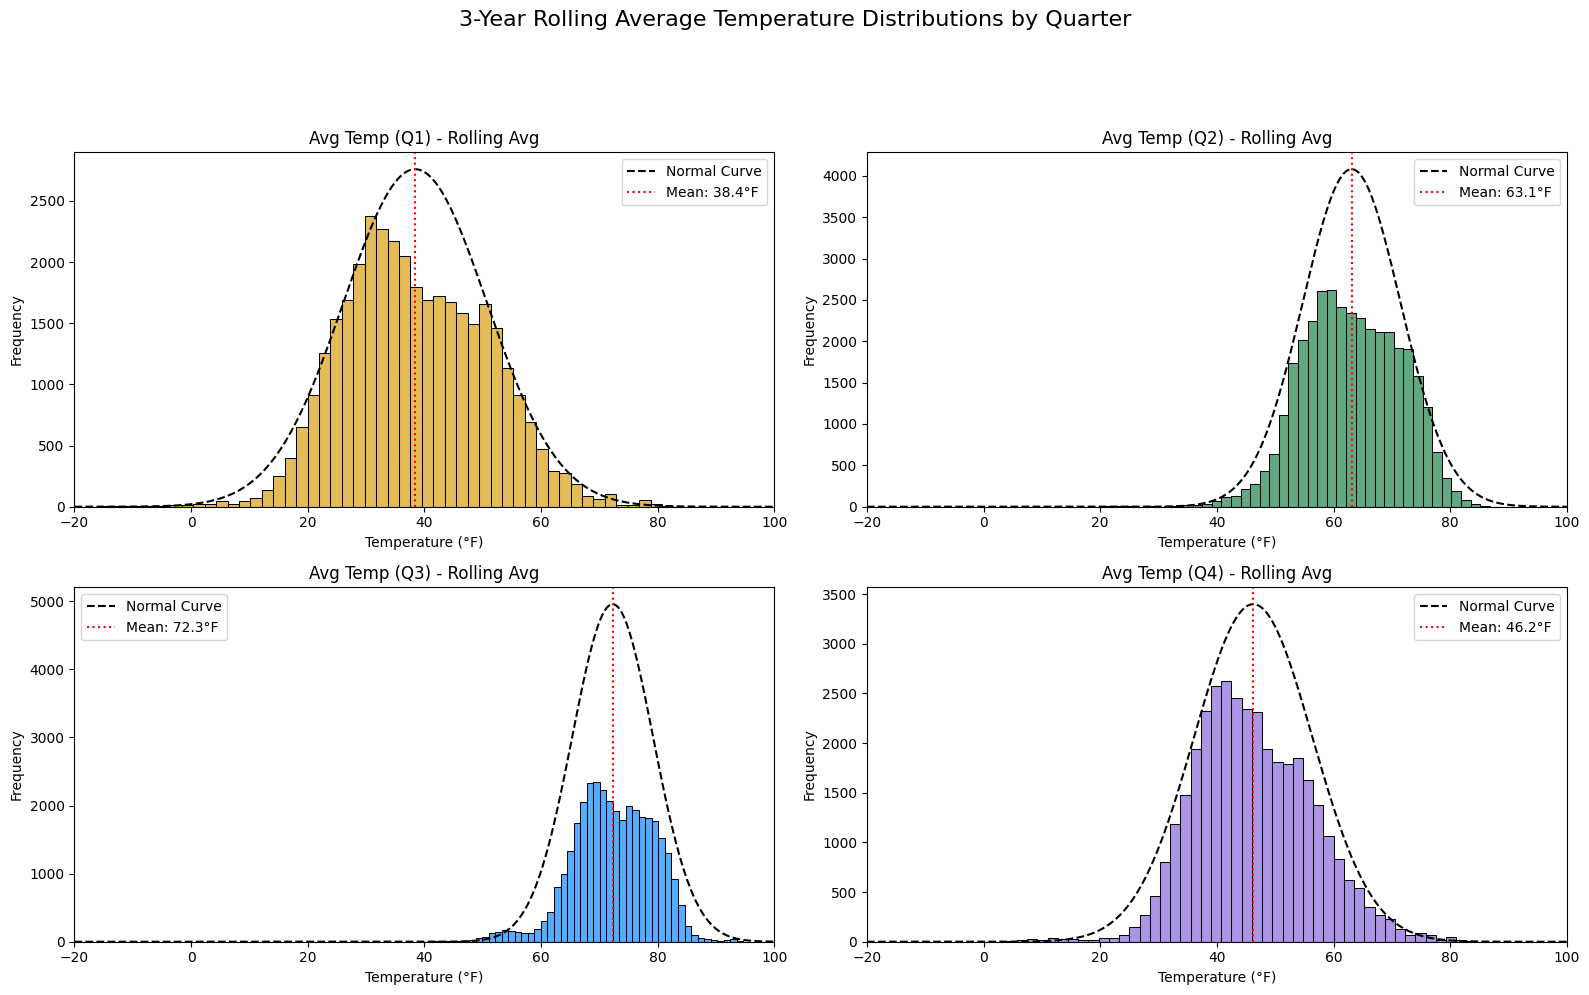

In [18]:
# Define your quarter-color mapping
colors = {
    1: "goldenrod",
    2: "seagreen",
    3: "dodgerblue",
    4: "mediumpurple"
}

# Set up the figure
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle("3-Year Rolling Average Temperature Distributions by Quarter", fontsize=16, y=1.02)

# Plot each quarter
for i, quarter in enumerate([1, 2, 3, 4]):
    row = i // 2
    col = i % 2

    colname = f"avg_temp_q{quarter}_roll3"
    data = weather_with_acs[colname].dropna()

    mean = data.mean()
    std = data.std()
    x_range = np.linspace(-20, 100, 500)
    y_norm = norm.pdf(x_range, mean, std) * len(data) * (120 / 50)

    sns.histplot(data, bins=50, ax=axs[row, col], color=colors[quarter])
    axs[row, col].plot(x_range, y_norm, color="black", linestyle="--", linewidth=1.5, label="Normal Curve")
    axs[row, col].axvline(mean, color="red", linestyle=":", linewidth=1.5, label=f"Mean: {mean:.1f}°F")

    axs[row, col].set_title(f"Avg Temp (Q{quarter}) - Rolling Avg")
    axs[row, col].set_xlabel("Temperature (°F)")
    axs[row, col].set_ylabel("Frequency")
    axs[row, col].set_xlim(-20, 100)
    axs[row, col].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [21]:
# Define the weather-related variables (lagged and rolling)
weather_vars = [col for col in training_data.columns if (
    col.startswith("avg_temp_") or
    col.startswith("max_temp") or
    col.startswith("total_precip") or
    col.startswith("heat_days_90F") or
    col.startswith("num_events_") or
    col.startswith("total_injuries") or
    col.startswith("total_deaths") or
    col.startswith("total_property_damage") or
    col.startswith("total_crop_damage")
) and ("_pct" not in col and "_change" not in col)]  # exclude derived deltas

# Keep only relevant columns + target
corr_df = training_data[["gini_index"] + weather_vars].copy()

# Compute correlations
weather_corr = corr_df.corr()["gini_index"].drop("gini_index").sort_values(key=abs, ascending=False)

# Show top 20 most correlated weather features
print("Top correlated weather variables with % change in median income:")
print(weather_corr.head(20))


Top correlated weather variables with % change in median income:
avg_temp_q4_roll3                     0.392305
avg_temp_q4_lag1                      0.385947
avg_temp_q1_roll3                     0.379933
avg_temp_q1_lag1                      0.366713
avg_temp_q2_roll3                     0.339004
avg_temp_q2_lag1                      0.334169
avg_temp_q3_roll3                     0.311938
avg_temp_q3_lag1                      0.309872
heat_days_90F_roll3                   0.233581
heat_days_90F_lag1                    0.228531
total_precip_roll3                    0.158812
total_precip_lag1                     0.153266
max_temp_roll3                        0.142622
max_temp_lag1                         0.132763
num_events_flash_flood_roll3          0.128074
num_events_flash_flood_lag1           0.105667
num_events_lightning_roll3            0.101782
num_events_lightning_lag1             0.081465
num_events_thunderstorm_wind_roll3    0.078767
num_events_thunderstorm_wind_lag1     0.07

In [22]:
# Define the weather-related variables (lagged and rolling)
weather_vars = [col for col in training_data.columns if (
    col.startswith("avg_temp_") or
    col.startswith("max_temp") or
    col.startswith("total_precip") or
    col.startswith("heat_days_90F") or
    col.startswith("num_events_") or
    col.startswith("total_injuries") or
    col.startswith("total_deaths") or
    col.startswith("total_property_damage") or
    col.startswith("total_crop_damage")
) and ("_pct" not in col and "_change" not in col)]  

training_data["pct_new_residents"] = (
    training_data["different_house_year_ago_different_city"] / training_data["total_pop"]
) * 100


# Keep only relevant columns + target
corr_df = training_data[["pct_new_residents"] + weather_vars].copy()

# Compute correlations
weather_corr = corr_df.corr()["pct_new_residents"].drop("pct_new_residents").sort_values(key=abs, ascending=False)

# Show top 20 most correlated weather features
print("Top correlated weather variables with % change in new residents:")
print(weather_corr.head(20))


Top correlated weather variables with % change in new residents:
avg_temp_q1_lag1              0.085607
avg_temp_q1_roll3             0.084700
total_precip_roll3            0.070072
total_precip_lag1             0.066922
avg_temp_q4_lag1              0.054137
avg_temp_q4_roll3             0.053947
num_events_flood_roll3       -0.049949
num_events_flood_lag1        -0.041082
heat_days_90F_roll3           0.028875
num_events_lightning_roll3    0.027184
heat_days_90F_lag1            0.027035
num_events_hail_roll3        -0.026573
num_events_hail_lag1         -0.023832
total_deaths_roll3            0.023171
num_events_lightning_lag1     0.021528
avg_temp_q2_lag1              0.019981
avg_temp_q2_roll3             0.019833
total_crop_damage_roll3      -0.017199
total_deaths_lag1             0.013754
num_events_tornado_roll3     -0.013738
Name: pct_new_residents, dtype: float64


In [23]:
# Define the weather-related variables (lagged and rolling)
weather_vars = [col for col in training_data.columns if (
    col.startswith("avg_temp_") or
    col.startswith("max_temp") or
    col.startswith("total_precip") or
    col.startswith("heat_days_90F") or
    col.startswith("num_events_") or
    col.startswith("total_injuries") or
    col.startswith("total_deaths") or
    col.startswith("total_property_damage") or
    col.startswith("total_crop_damage")
) and ("_pct" not in col and "_change" not in col)]  # exclude derived deltas

training_data["pct_moved_residents"] = (
    training_data["different_house_year_ago_same_city"] / training_data["total_pop"]
) * 100

# Keep only relevant columns + target
corr_df = training_data[["pct_moved_residents"] + weather_vars].copy()

# Compute correlations
weather_corr = corr_df.corr()["pct_moved_residents"].drop("pct_moved_residents").sort_values(key=abs, ascending=False)

# Show top 20 most correlated weather features
print("Top correlated weather variables with % of existing residents who moved:")
print(weather_corr.head(20))


Top correlated weather variables with % of existing residents who moved:
max_temp_roll3                        0.237628
num_events_hail_roll3                 0.231035
heat_days_90F_roll3                   0.228508
max_temp_lag1                         0.218156
heat_days_90F_lag1                    0.213975
num_events_hail_lag1                  0.190689
num_events_flash_flood_roll3          0.113498
num_events_flash_flood_lag1           0.092999
total_precip_roll3                    0.085657
total_precip_lag1                     0.080438
avg_temp_q3_lag1                      0.066985
avg_temp_q3_roll3                     0.066761
num_events_tornado_roll3              0.064383
num_events_lightning_roll3            0.053081
total_injuries_roll3                  0.048002
avg_temp_q2_roll3                     0.046584
avg_temp_q2_lag1                      0.046105
num_events_tornado_lag1               0.044683
num_events_lightning_lag1             0.043165
num_events_thunderstorm_wind_roll3